In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import pathlib

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
SEED = 19011997
SPLIT_VAL = 0.2
SPLIT_TEST = 0.06
BATCH_SIZE = 16
IMG_SIZE = (256,256)

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='constant') # oppure "nearest"
    ]
)

In [5]:
path_dataset_training = pathlib.Path('./dataset/split/training')
path_dataset_validation = pathlib.Path('./dataset/split/validation')
path_dataset_testing = pathlib.Path('./dataset/split/testing')

class_names = os.listdir(path_dataset_training)
print(class_names)

def import_from_directory(dataset_dir):
    return tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
        image_size=IMG_SIZE
    )

dataset_training = import_from_directory(path_dataset_training)
dataset_validation = import_from_directory(path_dataset_validation)
dataset_testing = import_from_directory(path_dataset_testing)

dataset_testing = dataset_testing.prefetch(buffer_size=64)
dataset_training = dataset_training.prefetch(buffer_size=64)
dataset_validation = dataset_validation.prefetch(buffer_size=64)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
Found 13829 files belonging to 14 classes.
Found 3545 files belonging to 14 classes.
Found 354 files belonging to 14 classes.


In [6]:
images_count = {}
for name in class_names:
    count = len(list(path_dataset_training.glob('{}/*.jpg'.format(name))))
    images_count[name] = count

max_class = max(images_count.values())
class_weights = {}
i = 0
for name in class_names:
    class_weights[i] = max_class / images_count[name]
    i += 1
print(class_weights)

{0: 6.041388518024032, 1: 12.891737891737892, 2: 10.011061946902656, 3: 4.84994640943194, 4: 3.986784140969163, 5: 3.2933042212518195, 6: 6.00929614873838, 7: 7.6825127334465195, 8: 8.333333333333334, 9: 23.567708333333332, 10: 3.5296411856474257, 11: 10.30751708428246, 12: 8.837890625, 13: 1.0}


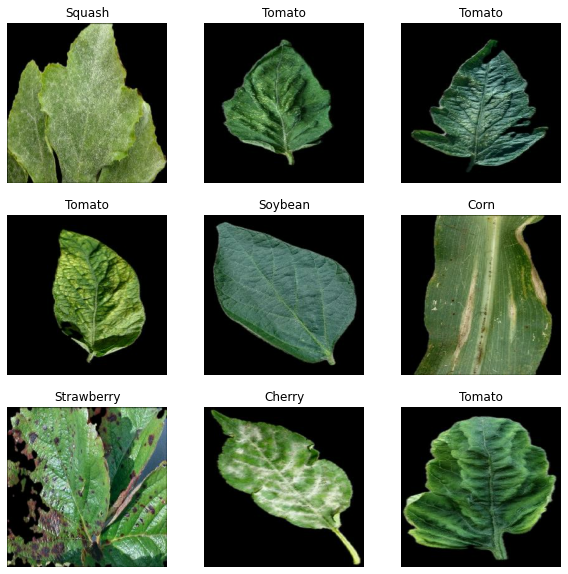

In [7]:
image_batch, label_batch = next(iter(dataset_training))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    index = np.argmax(np.array(label_batch[i]), axis=0)
    plt.title(class_names[index])
    plt.axis("off")

In [8]:
def make_base(input_Shape, trainable=False):
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        input_shape=input_Shape,
        include_top=False
    )

    base_model.trainable = trainable

    return base_model

def make_model(input_shape, trainable=False):
    base_model = make_base(input_shape, trainable)
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(23, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

def make_full(input_shape, num_classes, trainable=False):
    base_model = make_model(input_shape, trainable)
    base_model.load_weights('./models/sick/xception-w/fine')
    base_model.trainable = trainable
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)
    

model = make_full(IMG_SIZE + (3,), len(class_names))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 23)                20908607  
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                336       
Total params: 20,908,943
Trainable params: 336
Non-trainable params: 20,908,607
_________________________________________________________________


In [18]:
epochs = 24

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./models/sick/xception-full", save_best_only=True),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/24
865/865 [==============================] - 92s 88ms/step - loss: 10.2136 - accuracy: 0.6150 - mse: 0.0588 - val_loss: 1.6760 - val_accuracy: 0.9740 - val_mse: 0.0500
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/24
865/865 [==============================] - 58s 66ms/step - loss: 6.8573 - accuracy: 0.8870 - mse: 0.0394 - val_loss: 1.0384 - val_accuracy: 0.9766 - val_mse: 0.0311
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/24
865/865 [==============================] - 56s 64ms/step - loss: 4.5753 - accuracy: 0.8902 - mse: 0.0237 - val_loss: 0.6637 - val_accuracy: 0.9763 - val_mse: 0.0178
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/24
865/865 [==============================] - 57s 66ms/step - loss: 3.2466 - accuracy: 0.8886 - mse: 0.0152 - val_loss: 0.4461 - val_accuracy: 0.9763 - val_mse: 0.0102
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/24
865/865 [==============================] - 55s 63ms/step - loss: 2.4143 - accuracy: 0.8912 - mse: 0.0112 - val_loss: 0.3154 - val_accuracy: 0.9763 - val_mse: 0.0063
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/24
865/865 [==============================] - 63s 72ms/step - loss: 2.0473 - accuracy: 0.8866 - mse: 0.0098 - val_loss: 0.2361 - val_accuracy: 0.9763 - val_mse: 0.0044
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/24
865/865 [==============================] - 63s 72ms/step - loss: 1.7649 - accuracy: 0.8903 - mse: 0.0088 - val_loss: 0.1863 - val_accuracy: 0.9769 - val_mse: 0.0035
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/24
865/865 [==============================] - 62s 71ms/step - loss: 1.5933 - accuracy: 0.8923 - mse: 0.0084 - val_loss: 0.1535 - val_accuracy: 0.9769 - val_mse: 0.0031
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/24
865/865 [==============================] - 62s 71ms/step - loss: 1.4802 - accuracy: 0.8913 - mse: 0.0083 - val_loss: 0.1318 - val_accuracy: 0.9769 - val_mse: 0.0028
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/24
865/865 [==============================] - 64s 72ms/step - loss: 1.4442 - accuracy: 0.8917 - mse: 0.0082 - val_loss: 0.1171 - val_accuracy: 0.9769 - val_mse: 0.0027
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/24
865/865 [==============================] - 64s 73ms/step - loss: 1.3626 - accuracy: 0.8904 - mse: 0.0082 - val_loss: 0.1070 - val_accuracy: 0.9772 - val_mse: 0.0027
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/24
865/865 [==============================] - 65s 74ms/step - loss: 1.3660 - accuracy: 0.8898 - mse: 0.0082 - val_loss: 0.1002 - val_accuracy: 0.9777 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/24
865/865 [==============================] - 62s 71ms/step - loss: 1.4136 - accuracy: 0.8883 - mse: 0.0083 - val_loss: 0.0959 - val_accuracy: 0.9780 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/24
865/865 [==============================] - 57s 64ms/step - loss: 1.3453 - accuracy: 0.8926 - mse: 0.0080 - val_loss: 0.0926 - val_accuracy: 0.9780 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/24
865/865 [==============================] - 55s 63ms/step - loss: 1.3620 - accuracy: 0.8878 - mse: 0.0084 - val_loss: 0.0895 - val_accuracy: 0.9786 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/24
865/865 [==============================] - 57s 66ms/step - loss: 1.2898 - accuracy: 0.8941 - mse: 0.0079 - val_loss: 0.0878 - val_accuracy: 0.9788 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/24
865/865 [==============================] - 54s 62ms/step - loss: 1.3365 - accuracy: 0.8923 - mse: 0.0080 - val_loss: 0.0869 - val_accuracy: 0.9788 - val_mse: 0.0026
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/24
865/865 [==============================] - 53s 61ms/step - loss: 1.3128 - accuracy: 0.8926 - mse: 0.0080 - val_loss: 0.0858 - val_accuracy: 0.9791 - val_mse: 0.0025
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/24
865/865 [==============================] - 55s 62ms/step - loss: 1.3197 - accuracy: 0.8924 - mse: 0.0080 - val_loss: 0.0854 - val_accuracy: 0.9791 - val_mse: 0.0025
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/24
865/865 [==============================] - 55s 62ms/step - loss: 1.3632 - accuracy: 0.8886 - mse: 0.0083 - val_loss: 0.0843 - val_accuracy: 0.9794 - val_mse: 0.0025
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/24
865/865 [==============================] - 55s 63ms/step - loss: 1.3187 - accuracy: 0.8923 - mse: 0.0080 - val_loss: 0.0844 - val_accuracy: 0.9794 - val_mse: 0.0025
Epoch 22/24
865/865 [==============================] - 53s 62ms/step - loss: 1.2159 - accuracy: 0.8966 - mse: 0.0078 - val_loss: 0.0835 - val_accuracy: 0.9794 - val_mse: 0.0025
INFO:tensorflow:Assets written to: ./models/sick\xception-full\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/24
865/865 [==============================] - 54s 62ms/step - loss: 1.3152 - accuracy: 0.8945 - mse: 0.0079 - val_loss: 0.0837 - val_accuracy: 0.9794 - val_mse: 0.0025
Epoch 24/24
865/865 [==============================] - 53s 62ms/step - loss: 1.3206 - accuracy: 0.8933 - mse: 0.0080 - val_loss: 0.0837 - val_accuracy: 0.9794 - val_mse: 0.0025


In [19]:
model.save_weights('./models/sick/xception-w/full')

In [10]:
finemodel = make_full(IMG_SIZE + (3,), len(class_names), True)
finemodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 23)                20908607  
_________________________________________________________________
dropout_3 (Dropout)          (None, 23)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                336       
Total params: 20,908,943
Trainable params: 20,854,415
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
finemodel.load_weights('./models/sick/xception-w/full')

finemodel.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

# finemodel.evaluate(dataset_testing)
finemodel.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=8,
    class_weight=class_weights
)

Epoch 1/8
865/865 [==============================] - 232s 261ms/step - loss: 1.4799 - accuracy: 0.8944 - mse: 0.0079 - val_loss: 0.0807 - val_accuracy: 0.9828 - val_mse: 0.0020
Epoch 2/8
865/865 [==============================] - 222s 256ms/step - loss: 1.3082 - accuracy: 0.9085 - mse: 0.0071 - val_loss: 0.0463 - val_accuracy: 0.9873 - val_mse: 0.0014
Epoch 3/8
865/865 [==============================] - 220s 254ms/step - loss: 1.2601 - accuracy: 0.9145 - mse: 0.0069 - val_loss: 0.0405 - val_accuracy: 0.9893 - val_mse: 0.0011
Epoch 4/8
865/865 [==============================] - 222s 256ms/step - loss: 1.0707 - accuracy: 0.9374 - mse: 0.0054 - val_loss: 0.0394 - val_accuracy: 0.9915 - val_mse: 0.0010
Epoch 5/8
865/865 [==============================] - 221s 256ms/step - loss: 1.0590 - accuracy: 0.9449 - mse: 0.0052 - val_loss: 0.0318 - val_accuracy: 0.9915 - val_mse: 8.3488e-04
Epoch 6/8
865/865 [==============================] - 219s 253ms/step - loss: 0.9260 - accuracy: 0.9535 - mse: 0

In [14]:
finemodel.save('./models/sick/xception-full-fine')

INFO:tensorflow:Assets written to: ./models/sick/xception-full-fine\assets


C:\Users\bicycle\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [16]:
testmodel = tf.keras.models.load_model('./models/sick/xception-full-fine')
testmodel.evaluate(dataset_training)

865/865 [==============================] - 46s 52ms/step - loss: 0.0094 - accuracy: 0.9997 - mse: 7.6797e-05


[0.009397527202963829, 0.999710738658905, 7.679700502194464e-05]